# 2023-10-31 Saturated K3 rank evaluation

This notebook analyzes the cross-validation results of the 3D DTD model on the
killifish data (including featurization, HMM fitting, and binning) from 2023-07-26.
This latest dataset of binned counts consists of a 14410 days of recording (across ~70 fish),
with 144 time bins (at 10 minute intervals), for 100 behavioral syllables.
The goal is to find the most parsimonious model (i.e. choice of rank $(K_1, K_2, K_3)$.
which best fits the data.


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from pathlib import Path

import pandas as pd 
import numpy as onp
import wandb
import itertools

import seaborn as sns
import matplotlib.pyplot as plt

from kf_viz import draw_syllable_factors, draw_circadian_bases

sns.set_style("darkgrid")

## Load all runs associated with (K1=50, K2=4, K3=*)

Pull data from WandB server into a Pandas dataframe.

In [2]:
def get_results_df(entity, project, config_keys, summary_keys):
    """Project is specified by <entity/project-name>"""
    api = wandb.Api()

    # Project is specified by <entity/project-name>
    runs = api.runs(f"{entity}/{project}")

    run_results = {key: [] for key in itertools.chain(['id', 'name'], config_keys, summary_keys)}

    for run in runs: 

        # .summary contains the output keys/values for metrics like accuracy.
        # use .get to catch NaN runs (e.g. due to OOM)
        for key in summary_keys:
            run_results[key].append(run.summary.get(key,))

        # .config contains the hyperparameters.
        for key in config_keys:
            run_results[key].append(run.config[key])

        # .name is the human-readable name
        run_results['name'].append(run.name)
        run_results['id'].append(run._attrs['name'])

    return pd.DataFrame(run_results)

# Project is specified by <entity/project-name>
wnb_entity = 'eyz'
wnb_project = 'kf-dtd-231022'

config_keys = ['seed', 'k1', 'k2', 'k3']
summary_keys = ['pct_dev']

df = get_results_df(wnb_entity, wnb_project, config_keys, summary_keys)

In [3]:
# Choose runs for which (K1=50, K2=4)
df = df[(df['k1'] == 50) & (df['k2'] == 4)]

# Drop rows that have NaN pct_dev
df = df.dropna(axis=0)

print(f"{len(df)} total runs, {df['k3'].nunique()} unique K_3 ranks: {sorted(df['k3'].unique())}")

40 total runs, 12 unique K_3 ranks: [10, 20, 25, 30, 32, 35, 40, 45, 50, 60, 70, 100]


## Evaluate validation metric as a function of rank

Text(0.5, 1.0, 'highest pct_dev: 61.8, K=(50, 4, 100)')

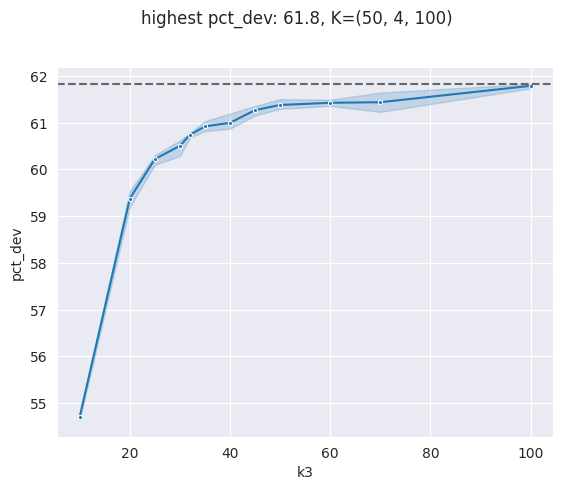

In [4]:
# get model rank with highest pct_dev
best_idx = df['pct_dev'].argmax()
best_rank = tuple(df.iloc[best_idx][['k1','k2','k3']])
best_pct_dev = df.iloc[best_idx]['pct_dev']

# plot results
sns.lineplot(data=df, x='k3', y='pct_dev', marker='.')
plt.gca().axhline(y=best_pct_dev, ls='--', c='0.4')
plt.gcf().suptitle(f'highest pct_dev: {best_pct_dev:.1f}, K={best_rank}', y=1.)


I expected the model with $K_3=100$ to be overfit to the data, and hence for the held-out log likelihood to be lower
than simpler models that do not overfit to the data. However, this may be too naive of an assumption.

# Fitted behavioral topics

In [5]:
def download_params(entity: str, project: str, run_id: str):
    """Return tuple of params for the given run."""

    api = wandb.Api()

    run = api.run(f"{entity}/{project}/{run_id}")

    # run.file(...).download(...) only seems to recognize paths relative to cwd
    rel_path = f'../temp/{run_id}'

    # If file already exists, do not re-download
    run.file("params.npz").download(root=rel_path, exist_ok=True)

    params = onp.load(Path(rel_path)/'params.npz')

    return params['G'], params['F1'], params['F2'], params['F3']


In [6]:
# get fitted K3 param associated with K3=100
df_100 = df[df['k3'] == 100]

params = [download_params(wnb_entity, wnb_project, _id)
          for _id in df_100['id']]

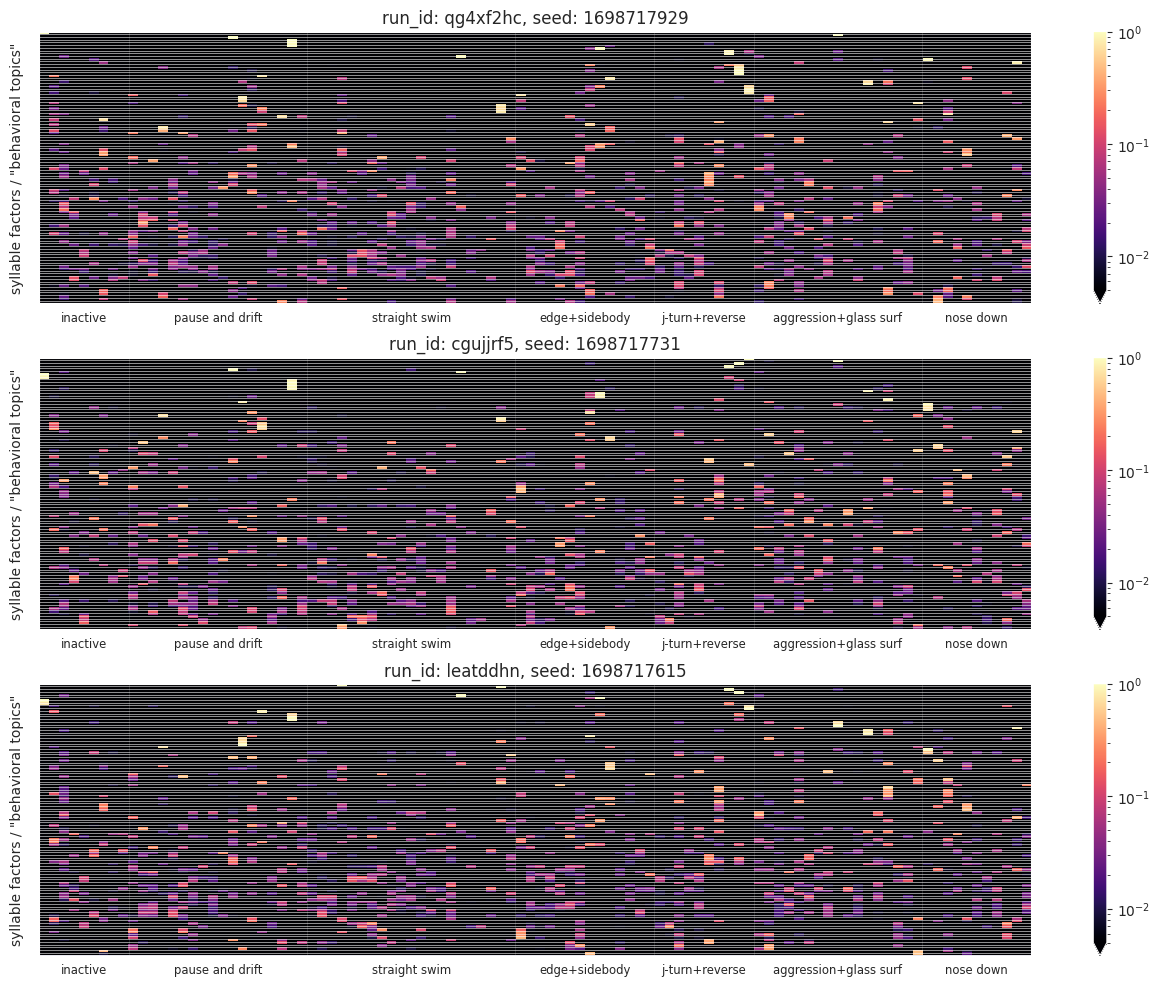

In [7]:
fig, axs = plt.subplots(nrows=len(df_100), figsize=(16,4*len(df_100)))

for i, (ax, _params) in enumerate(zip(axs, params)):
    draw_syllable_factors(_params, ax)
    ax.set_title(f"run_id: {df_100.iloc[i]['id']}, seed: {df_100.iloc[i]['seed']}")